# Entries by day

## Setup

## Loading &amp; Cleaning

In [21]:
#os.listdir(path_data % 2014)

In [22]:
# Get all filenames.
#years = [2014,2015]
#gc_files = []
#for year in years:
#    year_files = [(path_data % year + f) for f in os.listdir(path_data % year) if f[-4:] == '.csv']
#    gc_files = gc_files + year_files
    
# Load all files as DFs and concatenate.
#gate_count = [pd.read_csv(path) for path in gc_files]
#gate_count = pd.concat(gate_count)
#gate_count.reset_index(inplace=True,drop=True)

gate_count = pd.read_csv('data/Harvard IACS Capstone/gatecount_all/gatecounts.csv')


In [23]:
locations = pd.read_csv(path_locs)
locations.columns = [u'locationid', u'locationname', u'line_1', u'line_2', u'lat', u'lon']
locations.head()

,locationid,locationname,line_1,line_2,lat,lon
0,1002,Andrew Square,Red,NaN,42.329550,-71.056960
1,1004,JFK/U Mass,Red,NaN,42.321438,-71.052393
2,1005,North Quincy,Red,NaN,42.274816,-71.029176
3,1006,Wollaston,Red,NaN,42.265615,-71.019402
4,1007,Quincy Center,Red,NaN,42.250879,-71.004798


## Structure

In [24]:
# Start with the head.
print 'Head:'
gate_count.head()

Head:


,locationid,entries,exits,service_day,service_datetime
0,1002,0,1,2013-01-01 00:00:00,2013-01-01 03:00:00
1,1002,1,0,2013-01-01 00:00:00,2013-01-01 05:00:00
2,1002,2,0,2013-01-01 00:00:00,2013-01-01 05:15:00
3,1002,3,0,2013-01-01 00:00:00,2013-01-01 05:30:00
4,1002,6,0,2013-01-01 00:00:00,2013-01-01 05:45:00


In [25]:
# Show types.
print 'Types:'
print gate_count.dtypes
# Show nulls.
print '\nNulls:'
print np.sum(gate_count.isnull())
# Show min/max service times.
#print '\nMin service time: %d' % gate_count.servicetime.min()
#print 'Max service time: %d' % gate_count.servicetime.max()
# Num records.
print '\nNumber of records: %d' % len(gate_count)

Types:
locationid           int64
entries              int64
exits                int64
service_day         object
service_datetime    object
dtype: object

Nulls:
locationid          0
entries             0
exits               0
service_day         0
service_datetime    0
dtype: int64

Number of records: 3982009


**2.12 million records**

Data looks relatively clean. 0 nulls.

Service times show a strange range (300 $\rightarrow$ 2645) + 300. Unclear why this is (UTC is not +3). It may be that all times are offset by 3 hours, or that values ≥ 2400 should loop back around to 0.

### Clean Up Dates

Dates are currently strings and integers. We'll want to use formal date/time representations for them.

In [26]:
# Convert main date column.
gate_count.service_datetime = pd.to_datetime(gate_count.service_datetime)
gate_count.service_day = pd.to_datetime(gate_count.service_day)

# Convert service time to min 0. Nevermind: it's unclear how we should do this.
# gate_count.servicetime = gate_count.servicetime-300
# Convert service time to minutes.
#gate_count['servicetimeminutes'] = np.floor((gate_count.servicetime-300) / 100)*60 + np.mod(gate_count.servicetime,100)

# Populate our dedicated datetime column with converted servicedate values.
#gate_count['servicedatetime'] = gate_count.servicedate
# Add the timedeltas.
#gate_count['servicedatetime'] += np.array(gate_count.servicetimeminutes, dtype='timedelta64[m]')

In [27]:
# Show head to make sure we have what we're looking for.

gate_count.columns = [u'locationid', u'entries', u'exits', u'servicedate', u'service_datetime']
gate_count.head()

,locationid,entries,exits,servicedate,service_datetime
0,1002,0,1,2013-01-01,2013-01-01 03:00:00
1,1002,1,0,2013-01-01,2013-01-01 05:00:00
2,1002,2,0,2013-01-01,2013-01-01 05:15:00
3,1002,3,0,2013-01-01,2013-01-01 05:30:00
4,1002,6,0,2013-01-01,2013-01-01 05:45:00


In [28]:
type(gate_count.servicedate[0])

pandas.tslib.Timestamp

## Summary Statistics

In [29]:
# Metric totals.
print 'Total entries:        ',gate_count.entries.sum()
print 'Total exits:          ',gate_count.exits.sum()
print 'Ratio (entries/exits):',float(gate_count.entries.sum())/gate_count.exits.sum()

Total entries:         322966487
Total exits:           267648718
Ratio (entries/exits): 1.20668049305


**170 million** entries, **140 million** exits. Remember, data is not annual (it includes Jan and part of Feb 2015). Looks like roughly **6 entries per 5 exits**.

## Distributions

Charts below show distributions at various levels of aggregation: non-aggregated (effectively by location and date/time), by date, and by location/date.

In [40]:
# Store several convenient distributions.

# Date.
gate_count_by_date = gate_count[['servicedate','entries','exits']].groupby('servicedate').agg(np.sum)

# Location-date.
gate_count_by_location_date = gate_count[['locationid','servicedate','entries','exits']].groupby(['locationid','servicedate']).agg(np.sum)

# Time.
#gate_count_by_time = gate_count[['servicetimeminutes','entries','exits']].groupby('servicetimeminutes').agg(np.sum)

In [31]:
gate_count_by_date.head()


,entries,exits
servicedate,,
2013-01-01,146267,126630
2013-01-02,419529,340972
2013-01-03,435656,355453
2013-01-04,471005,385581
2013-01-05,239873,205980


In [32]:
gate_count_by_location_date.head()

entries  exits
locationid servicedate                
1002       2013-01-01      1892    469
           2013-01-02      5134    959
           2013-01-03      5733    985
           2013-01-04      6125   1102
           2013-01-05      3410    839

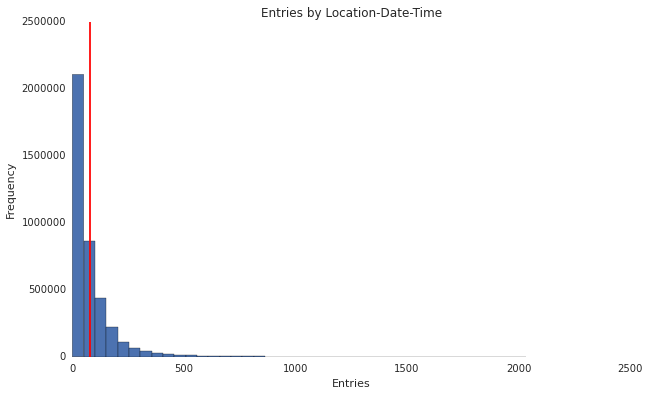

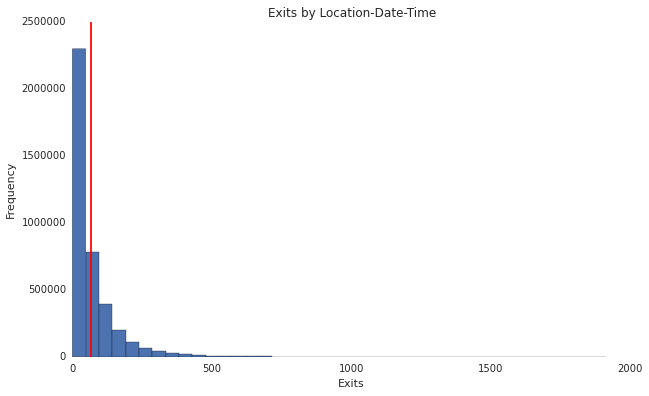

In [33]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count.entries, bins=40)
plt.vlines(gate_count.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Location-Date-Time')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

# Plot distribution of exits.
plt.figure(figsize=(10,6))
plt.hist(gate_count.exits, bins=40)
plt.vlines(gate_count.exits.mean(),0,plt.ylim()[1],colors='r')
plt.title('Exits by Location-Date-Time')
plt.xlabel('Exits') ; plt.ylabel('Frequency')
plt.show()

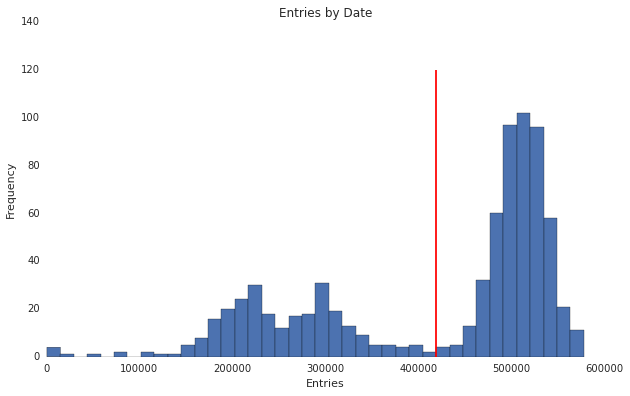

In [34]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count_by_date.entries, bins=40)
plt.vlines(gate_count_by_date.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Date')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

Exits looks similar. Note that there are probably both annual and weekly trends meshed together here. The latter predicts a bimodal distribution.

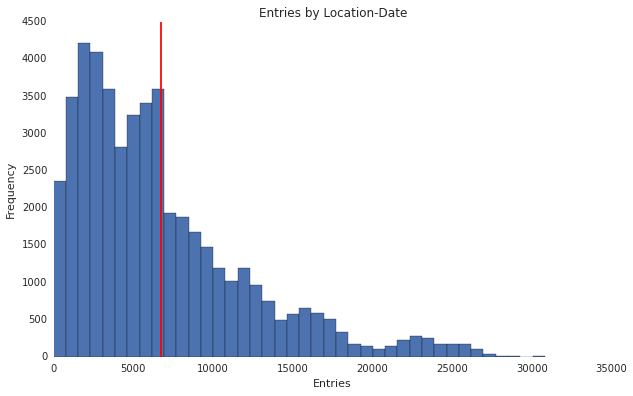

In [35]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count_by_location_date.entries, bins=40)
plt.vlines(gate_count_by_location_date.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Location-Date')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

## Time Trends

In [36]:
print gate_count_by_date.index.shape
print gate_count_by_date.entries.shape

(772L,)
(772,)


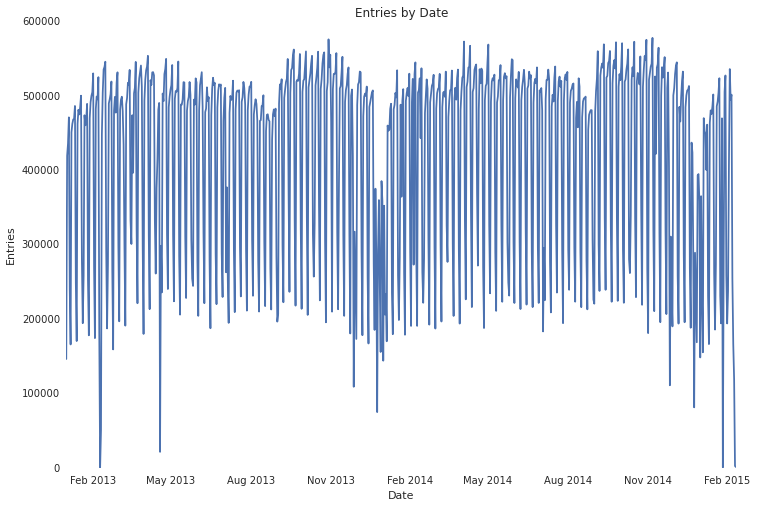

In [37]:
# Plot entries by date.
plt.figure(figsize=(12,8))
plt.plot(gate_count_by_date.index,gate_count_by_date.entries)
plt.title('Entries by Date')
plt.xlabel('Date') ; plt.ylabel('Entries')
plt.show()

Pretty obvious weekday-weekend divide.

In [41]:
# Plot entries, exits by time. Very rough plot (only using minutes of day).
#plt.figure(figsize=(12,8))
#plt.plot(gate_count_by_time.index, gate_count_by_time.entries,      label='Entries')
#plt.plot(gate_count_by_time.index, gate_count_by_time.exits,   'r', label='Exits')
#plt.title('Entries/Exits by Date')
#plt.xlabel('Time (Minutes of Day)')
#plt.legend()
#plt.show()

Overlap between entries and exits looks pretty intuitive: in the aggregate, people enter and then seem to exit somewhat later. We lose some exits due to gates staying open for >1 person and people getting off in ways that aren't tracked. But visually, it looks like we "lose" more exits later in the day. I wonder if that happens as people board through a subway entrance but exit (untracked) off of the Green Line. Maybe farther-out stops have more exits without gates.

Also, it looks like orignial `servicetime` values < 2400 are all accurate and that values ≥ 2400 actually represent times after midnight. A morning peak at ~300 (as shown) is 5am; adding three hours would put the morning peak at 8am (much more reasonable). So to clean up times, we should *not* simply subtract 300.

## Predicting entries by day

### Extract features

To take the service date data fully into account in the regression model, will expand the date into set of categorical features encoded in boolean form using the 1-of-K encoding. This should make it possible to identify linear dependencies on periodic events on typical seasonal cycles.

Here are the features extracted from the date:

-hour of the day (24 boolean features)
-day of the week (7 boolean features)
-day of the month (up to 31 boolean features)
-month of the year (12 boolean features)
-year (as many boolean features as they are different years in the dataset) ...

Additionally, will also extract the date as a single float. That numerical feature should make it possible to identify long term trends between the output of the event date: e.g. a linear slope in a regression problem to better predict entries in upcoming years that cannot be encoded with the boolean categorical variable for the year feature.


In [42]:
gate_count.head()

,locationid,entries,exits,servicedate,service_datetime
0,1002,0,1,2013-01-01,2013-01-01 03:00:00
1,1002,1,0,2013-01-01,2013-01-01 05:00:00
2,1002,2,0,2013-01-01,2013-01-01 05:15:00
3,1002,3,0,2013-01-01,2013-01-01 05:30:00
4,1002,6,0,2013-01-01,2013-01-01 05:45:00


In [43]:
#get aggregated DF
gate_count_by_location_date = gate_count[['locationid','servicedate','entries','exits']].groupby(['locationid','servicedate']).agg(np.sum)

gate_count_by_location_date = gate_count_by_location_date.reset_index(level=0)
gate_count_by_location_date = gate_count_by_location_date.reset_index(level=0)
gate_count_by_location_date.head()


,servicedate,locationid,entries,exits
0,2013-01-01,1002,1892,469
1,2013-01-02,1002,5134,959
2,2013-01-03,1002,5733,985
3,2013-01-04,1002,6125,1102
4,2013-01-05,1002,3410,839


In [44]:
#service_date = pd.DatetimeIndex(gate_count.servicedate)
service_date = pd.DatetimeIndex(gate_count_by_location_date.servicedate)
service_years = service_date.year
service_months = service_date.month
service_days = service_date.day
service_weekdays = service_date.weekday+1

In [45]:
print service_weekdays

[2 3 4 ..., 1 2 3]


In [46]:
print service_date.shape
print service_years.shape
print service_months.shape
print service_days.shape
print service_weekdays.shape


(48064L,)
(48064L,)
(48064L,)
(48064L,)
(48064L,)


In [47]:
print service_years
print service_months
print service_days
print service_weekdays

[2013 2013 2013 ..., 2015 2015 2015]
[1 1 1 ..., 2 2 2]
[ 1  2  3 ...,  9 10 11]
[2 3 4 ..., 1 2 3]


In [48]:
years_bin = pd.get_dummies(service_years, prefix='dYear')
print years_bin.shape
years_bin.head()

(48064, 3)


,dYear_2013,dYear_2014,dYear_2015
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [49]:
months_bin = pd.get_dummies(service_months, prefix='dMonth')
print months_bin.shape
months_bin.head()

(48064, 12)


,dMonth_1,dMonth_2,dMonth_3,dMonth_4,dMonth_5,dMonth_6,dMonth_7,dMonth_8,dMonth_9,dMonth_10,dMonth_11,dMonth_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [50]:

days_bin = pd.get_dummies(service_days, prefix='dDay')
print days_bin.shape
days_bin.head()

(48064, 31)


,dDay_1,dDay_2,dDay_3,dDay_4,dDay_5,dDay_6,dDay_7,dDay_8,dDay_9,dDay_10,...,dDay_22,dDay_23,dDay_24,dDay_25,dDay_26,dDay_27,dDay_28,dDay_29,dDay_30,dDay_31
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
daysweek_bin = pd.get_dummies(service_weekdays, prefix='dDayofWeek')
print daysweek_bin.shape
daysweek_bin.head()

(48064, 7)


,dDayofWeek_1,dDayofWeek_2,dDayofWeek_3,dDayofWeek_4,dDayofWeek_5,dDayofWeek_6,dDayofWeek_7
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0


In [52]:
#add historical gate entries as attributes (last 10 days)
historical_day_entries = gate_count_by_location_date.ix[:,:2]
historical_day_entries.head()

for day in xrange(1,10):
    day_entries = gate_count_by_location_date[['locationid','servicedate','entries']]
    day_entries.servicedate = day_entries.servicedate + np.timedelta64(day,'D')
    day_entries.rename(columns={'entries':'entries_-'+str(day)+'d'}, inplace=True)
    historical_day_entries = historical_day_entries.merge(day_entries, on=['locationid','servicedate'])
    historical_day_entries.fillna(0, inplace=True)


C:\Users\Lyla\Anaconda\lib\site-packages\pandas\core\generic.py:1858: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  self[name] = value
C:\Users\Lyla\Anaconda\lib\site-packages\pandas\core\frame.py:2194: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
  **kwargs)


In [53]:
print historical_day_entries.shape
historical_day_entries.head()

(46816, 11)


,servicedate,locationid,entries_-1d,entries_-2d,entries_-3d,entries_-4d,entries_-5d,entries_-6d,entries_-7d,entries_-8d,entries_-9d
0,2013-01-10,1002,6055,6002,5998,2311,3410,6125,5733,5134,1892
1,2013-01-11,1002,5940,6055,6002,5998,2311,3410,6125,5733,5134
2,2013-01-12,1002,6285,5940,6055,6002,5998,2311,3410,6125,5733
3,2013-01-13,1002,3559,6285,5940,6055,6002,5998,2311,3410,6125
4,2013-01-14,1002,2382,3559,6285,5940,6055,6002,5998,2311,3410


In [54]:
#add historical gate entries as attributes (last 10 of the same week day)
historical_weekday_entries = gate_count_by_location_date.ix[:,:2]
historical_weekday_entries.head()

for day in xrange(1,10):
    day_entries = gate_count_by_location_date[['locationid','servicedate','entries']]
    day_entries.servicedate = day_entries.servicedate + np.timedelta64(7*day,'D')
    day_entries.rename(columns={'entries':'weekdayentries_-'+str(day)+'w'}, inplace=True)
    historical_weekday_entries = historical_weekday_entries.merge(day_entries, on=['locationid','servicedate'])
    historical_weekday_entries.fillna(0, inplace=True)


In [55]:
print historical_weekday_entries.shape
historical_weekday_entries.head()

(43511, 11)


,servicedate,locationid,weekdayentries_-1w,weekdayentries_-2w,weekdayentries_-3w,weekdayentries_-4w,weekdayentries_-5w,weekdayentries_-6w,weekdayentries_-7w,weekdayentries_-8w,weekdayentries_-9w
0,2013-03-05,1002,6298,5749,6036,6361,5959,5941,6286,6002,1892
1,2013-03-06,1002,5721,5730,6802,6475,6185,5869,5915,6055,5134
2,2013-03-07,1002,6242,5970,6786,6503,6070,5528,6231,5940,5733
3,2013-03-08,1002,6690,6000,6829,2615,6660,5822,6295,6285,6125
4,2013-03-09,1002,3828,3236,3550,15,3533,3018,3469,3559,3410


In [56]:
#add historical gate entries as attributes (last 3 of the same day of the year)
historical_year_entries = gate_count_by_location_date.ix[:,:2]
historical_year_entries.head()

for day in xrange(1,4):
    day_entries = gate_count_by_location_date[['locationid','servicedate','entries']]
    day_entries.servicedate = day_entries.servicedate + np.timedelta64(day,'Y')
    day_entries.rename(columns={'entries':'yearlyentries_-'+str(day)+'y'}, inplace=True)
    #day_entries.servicedate = pd.to_datetime(day_entries.servicedate)
    day_entries.servicedate = map(lambda i: i.replace(hour=0, minute=0, second=0, microsecond=0), day_entries.servicedate) 

    historical_year_entries = historical_year_entries.merge(day_entries,how='left', on=['locationid','servicedate'])
    historical_year_entries.fillna(1, inplace=True)

In [57]:
print historical_year_entries.shape
historical_year_entries.head()

(48064, 5)


,servicedate,locationid,yearlyentries_-1y,yearlyentries_-2y,yearlyentries_-3y
0,2013-01-01,1002,1,1,1
1,2013-01-02,1002,1,1,1
2,2013-01-03,1002,1,1,1
3,2013-01-04,1002,1,1,1
4,2013-01-05,1002,1,1,1


In [58]:
print gate_count_by_location_date.shape
gate_count_by_location_date.head()

(48064, 4)


,servicedate,locationid,entries,exits
0,2013-01-01,1002,1892,469
1,2013-01-02,1002,5134,959
2,2013-01-03,1002,5733,985
3,2013-01-04,1002,6125,1102
4,2013-01-05,1002,3410,839


In [59]:
#historical_year_entries = gate_count_by_location_date.ix[:,:2]

day=3
day_entries = gate_count_by_location_date[['locationid','servicedate','entries']]
day_entries.servicedate = day_entries.servicedate + np.timedelta64(day,'Y')
day_entries.rename(columns={'entries':'yearlyentries_-'+str(day)+'y'}, inplace=True)
#day_entries.servicedate = pd.to_datetime(day_entries.servicedate)
day_entries.servicedate = map(lambda i: i.replace(hour=0, minute=0, second=0, microsecond=0), day_entries.servicedate) 

historical_year_entries = historical_year_entries.merge(day_entries, how='left', on=['locationid','servicedate'])
historical_year_entries.fillna(0, inplace=True)

In [60]:
print historical_year_entries.shape
historical_year_entries.head()

(48064, 6)


,servicedate,locationid,yearlyentries_-1y,yearlyentries_-2y,yearlyentries_-3y_x,yearlyentries_-3y_y
0,2013-01-01,1002,1,1,1,0
1,2013-01-02,1002,1,1,1,0
2,2013-01-03,1002,1,1,1,0
3,2013-01-04,1002,1,1,1,0
4,2013-01-05,1002,1,1,1,0


In [61]:
print historical_year_entries.shape
print sum(historical_year_entries['yearlyentries_-1y'])
historical_year_entries.sort(['yearlyentries_-1y'], ascending=[0])


(48064, 6)
165299504.0


,servicedate,locationid,yearlyentries_-1y,yearlyentries_-2y,yearlyentries_-3y_x,yearlyentries_-3y_y
15579,2014-04-13,1035,30822,1,1,0
15626,2014-05-30,1035,30417,1,1,0
15768,2014-10-19,1035,30043,1,1,0
4290,2014-03-22,1009,28982,1,1,0
15522,2014-02-15,1035,28441,1,1,0
15571,2014-04-05,1035,27623,1,1,0
4521,2014-11-08,1009,27556,1,1,0
4486,2014-10-04,1009,27485,1,1,0
15760,2014-10-11,1035,27377,1,1,0
15564,2014-03-29,1035,27133,1,1,0


In [62]:
print day_entries.shape
print day_entries.servicedate[0].replace(hour=0, minute=0, second=0, microsecond=0)
print gate_count_by_location_date.servicedate[0]

(48064, 3)
2016-01-01 00:00:00
2013-01-01 00:00:00


### Build the feature matrix

In [63]:
#build the feature matrix
features_full = pd.concat([gate_count_by_location_date, years_bin,months_bin,days_bin, daysweek_bin], axis=1)
features_full = features_full.merge(historical_day_entries, on=['locationid','servicedate'])
features_full = features_full.merge(historical_weekday_entries, on=['locationid','servicedate'])
features_full = features_full.merge(historical_year_entries, on=['locationid','servicedate'])


#finalize datasets to be used
data_full=features_full
features_full = features_full.drop( ['servicedate', 'exits'], axis=1) #(['locationid','servicedate','entries', 'exits'], axis=1)

print features_full.shape
print data_full.shape

(43006, 77)
(43006, 79)


In [64]:
features_full.head()

,locationid,entries,dYear_2013,dYear_2014,dYear_2015,dMonth_1,dMonth_2,dMonth_3,dMonth_4,dMonth_5,...,weekdayentries_-4w,weekdayentries_-5w,weekdayentries_-6w,weekdayentries_-7w,weekdayentries_-8w,weekdayentries_-9w,yearlyentries_-1y,yearlyentries_-2y,yearlyentries_-3y_x,yearlyentries_-3y_y
0,1002,6347,1,0,0,0,0,1,0,0,...,6361,5959,5941,6286,6002,1892,1,1,1,0
1,1002,6326,1,0,0,0,0,1,0,0,...,6475,6185,5869,5915,6055,5134,1,1,1,0
2,1002,5748,1,0,0,0,0,1,0,0,...,6503,6070,5528,6231,5940,5733,1,1,1,0
3,1002,5522,1,0,0,0,0,1,0,0,...,2615,6660,5822,6295,6285,6125,1,1,1,0
4,1002,3988,1,0,0,0,0,1,0,0,...,15,3533,3018,3469,3559,3410,1,1,1,0


In [65]:

#add location info to full data
data_full = data_full.merge(locations, how='left', on=['locationid'])
print data_full.shape
data_full.head()

(43006, 84)


,servicedate,locationid,entries,exits,dYear_2013,dYear_2014,dYear_2015,dMonth_1,dMonth_2,dMonth_3,...,weekdayentries_-9w,yearlyentries_-1y,yearlyentries_-2y,yearlyentries_-3y_x,yearlyentries_-3y_y,locationname,line_1,line_2,lat,lon
0,2013-03-05,1002,6347,1050,1,0,0,0,0,1,...,1892,1,1,1,0,Andrew Square,Red,NaN,42.32955,-71.05696
1,2013-03-06,1002,6326,1018,1,0,0,0,0,1,...,5134,1,1,1,0,Andrew Square,Red,NaN,42.32955,-71.05696
2,2013-03-07,1002,5748,787,1,0,0,0,0,1,...,5733,1,1,1,0,Andrew Square,Red,NaN,42.32955,-71.05696
3,2013-03-08,1002,5522,856,1,0,0,0,0,1,...,6125,1,1,1,0,Andrew Square,Red,NaN,42.32955,-71.05696
4,2013-03-09,1002,3988,1054,1,0,0,0,0,1,...,3410,1,1,1,0,Andrew Square,Red,NaN,42.32955,-71.05696


### Predictive Models

In [66]:
#Simple linear case
def predict(locationid=''):
    if locationid!='':
        features_byloc = features_full.ix[features_full.locationid == locationid,:]
        
    else:
        features_byloc = features_full

    # Create the simplest basis, with just the time and an offset.
    Y_train = np.array(features_byloc.entries)
    
    features_byloc = features_byloc.drop( ['locationid', 'entries'], axis=1) 
    
    X_train = np.array(features_byloc)

    

    #define parameters of model
    #clf = RandomForestRegressor() 
    clf = LinearRegression()
    
    #fit model using selected regresion
    clf.fit(X_train, Y_train)

    return clf.score(X_train, Y_train), clf.predict(X_train), Y_train

In [67]:
print predict()[0]

0.927006424117


The R^2 score was calculated for a variety of regression models using all data for training (and all locations). The following is a summary of the results:
    
    
- 0.901581367762 Ridge Regression
- 0.901581367763 Linear Regression
- 0.901547209215 Lasso Regression
- 0.896951413929 Elastic Net (max iter=5000)
- 0.987888261222 Random Forest Regressor
- 0.988601312525 -d6
- 0.987834855629 10 days


#### R^2 score for training data:

In [68]:
locationpreds = locations.copy()
locationpreds['R2All'] = 0.0

for index, row in locationpreds.iterrows():
    locid = row.locationid
    #print locid
    pred = predict(locid)[0]
    #print pred
    locationpreds.R2All[index] = pred
    #break
    
locationpreds.head()

,locationid,locationname,line_1,line_2,lat,lon,R2All
0,1002,Andrew Square,Red,NaN,42.329550,-71.056960,0.764310
1,1004,JFK/U Mass,Red,NaN,42.321438,-71.052393,0.773012
2,1005,North Quincy,Red,NaN,42.274816,-71.029176,0.844802
3,1006,Wollaston,Red,NaN,42.265615,-71.019402,0.819278
4,1007,Quincy Center,Red,NaN,42.250879,-71.004798,0.819924


In [69]:
#highest R^2
locationpreds.sort(['R2All'], ascending=[0]).head()

,locationid,locationname,line_1,line_2,lat,lon,R2All
11,1015,Suffolk Downs,Blue,NaN,42.388402,-71.000358,0.922593
15,1019,Bowdoin,Blue,NaN,42.361457,-71.062129,0.866923
46,1077,State Street,Orange,Blue,42.358897,-71.057795,0.860072
8,1012,Aquarium,Blue,NaN,42.359456,-71.053570,0.854124
5,1009,South Station,Red,NaN,42.351710,-71.055000,0.845935


In [70]:
pred_red= locationpreds[locationpreds['line_1'] == 'Red']
pred_blue= locationpreds[locationpreds['line_1'] == 'Blue']
pred_green= locationpreds[locationpreds['line_1'] == 'Green']
pred_orange= locationpreds[locationpreds['line_1'] == 'Orange']
pred_silver= locationpreds[locationpreds['line_1'] == 'Silver']


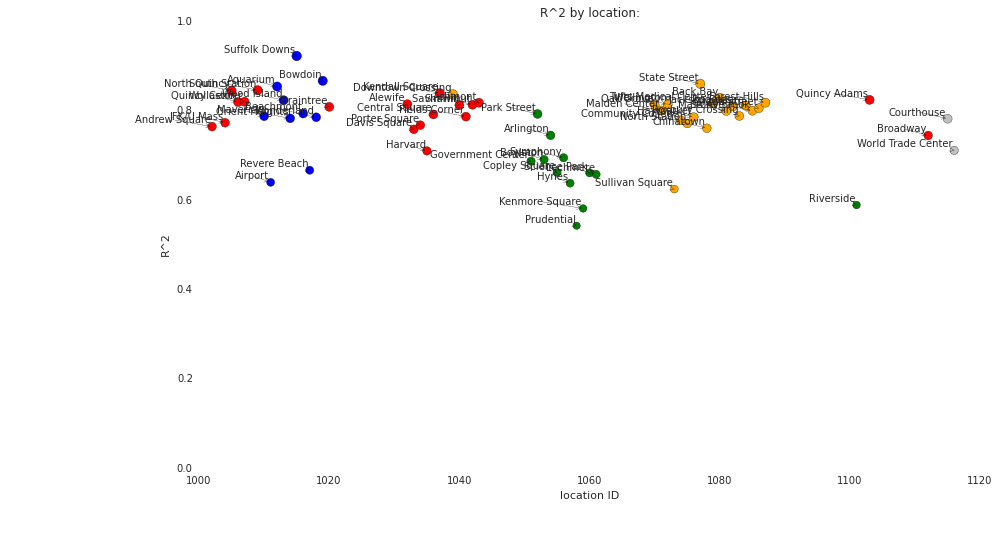

In [71]:

labels = locationpreds.locationname.tolist()

plt.figure(figsize=(14,8))
#plt.subplots_adjust(bottom = 0.1)

plt.scatter(
    locationpreds.locationid, locationpreds.R2All, marker = 'o', 
    c = locationpreds.line_1, s = locationpreds.R2All*100,
    cmap = plt.get_cmap('Spectral'))

for label, x, y in zip(labels, locationpreds.locationid, locationpreds.R2All):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-2, 2),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.title('R^2 by location:')# + str(locid) + ' ' + np.array(locinfo.locationname)[0])
plt.xlabel('location ID') 
plt.ylabel('R^2')
plt.axis([1000, 1120, 0, 1])
plt.show()

In [72]:
def plotEntriesByLoc2(locid):

    locdata = gate_count_by_location_date[gate_count_by_location_date['locationid'] == locid]
    r = map(lambda i: i.to_datetime(), locdata.servicedate) 

    locinfo = locationpreds[locationpreds['locationid'] == locid]


    years    = mdates.YearLocator()   # every year
    months   = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    monthsFmt = mdates.DateFormatter('%m')

    score, pred, test = predict(locid)
    
    #plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))
    #ax.plot(r, locdata.entries, color=np.array(locinfo.line_1)[0], alpha = .1)
    ax.plot(range(pred.shape[0]), pred, color=np.array(locinfo.line_1)[0], alpha = .9)
    
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)


    #datemin = datetime.date(locdata.servicedate.min().year, 1, 1)
    #datemax = datetime.date(locdata.servicedate.max().year+1, 1, 1)
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
    def price(x): return '$%1.2f'%x
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = price
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    #fig.autofmt_xdate()

    plt.title('Entries by location:' + str(locid) + ' ' + np.array(locinfo.locationname)[0])
    plt.xlabel('Date') 
    plt.ylabel('Entries')
    plt.show()

In [73]:
def plotEntriesByLoc(locid):
    
    locinfo = locationpreds[locationpreds['locationid'] == locid]

    score, pred, test = predict(locid)
    
    #plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))
    x = range(test.shape[0])
    #ax.plot(r, locdata.entries, color=np.array(locinfo.line_1)[0], alpha = .1)
    ax.plot(x, test, color='gray', alpha = .5)
    ax.plot(range(pred.shape[0]), pred, color=np.array(locinfo.line_1)[0], alpha = .9)
    
    plt.xticks(np.arange(min(x), max(x)+1, 30.0))

    labels=['Jan 2013','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan 2014','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.xaxis.set_ticklabels(labels,rotation=25)
    
    plt.title('Entries and predictions by location: ' + str(locid) + ' ' + np.array(locinfo.locationname)[0])
    plt.xlabel('Date') 
    plt.ylabel('Entries')
    
    plt.show

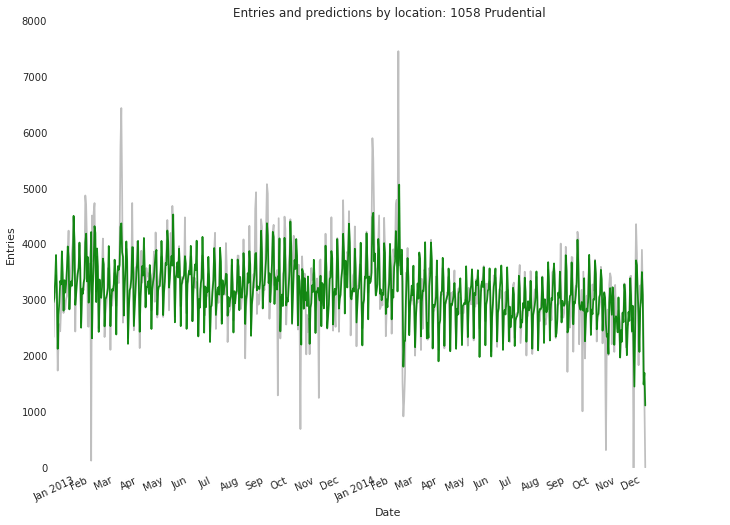

In [74]:
plotEntriesByLoc(1058) #prudential

In [75]:
#lowest R^2s
locationpreds.sort(['R2All'], ascending=[1]).head()

,locationid,locationname,line_1,line_2,lat,lon,R2All
35,1058,Prudential,Green,NaN,42.345636,-71.081586,0.542276
36,1059,Kenmore Square,Green,NaN,42.348797,-71.095296,0.580994
57,1101,Riverside,Green,NaN,42.337111,-71.251734,0.588657
42,1073,Sullivan Square,Orange,NaN,42.385755,-71.077080,0.624428
34,1057,Hynes,Green,NaN,42.348097,-71.088396,0.637578


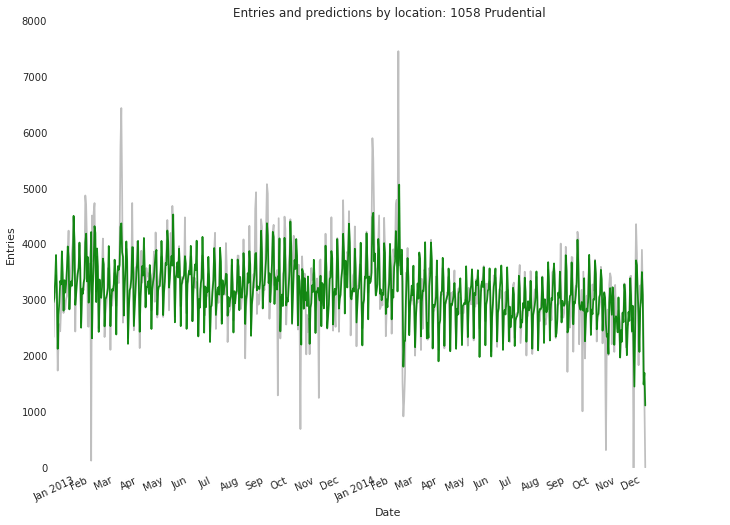

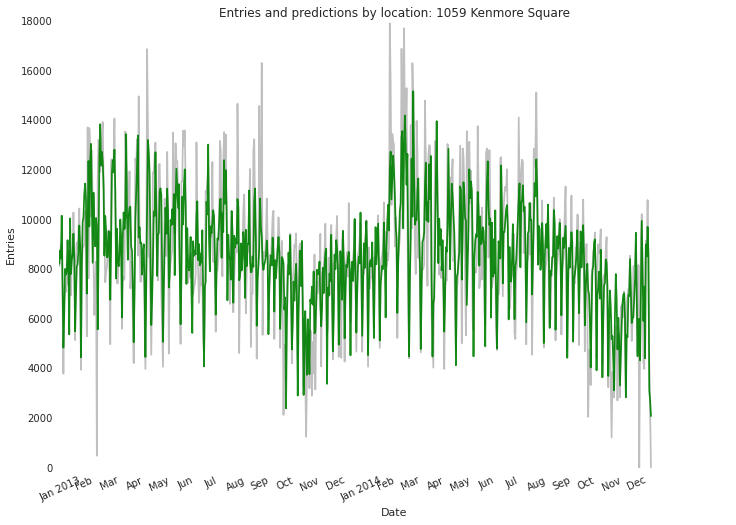

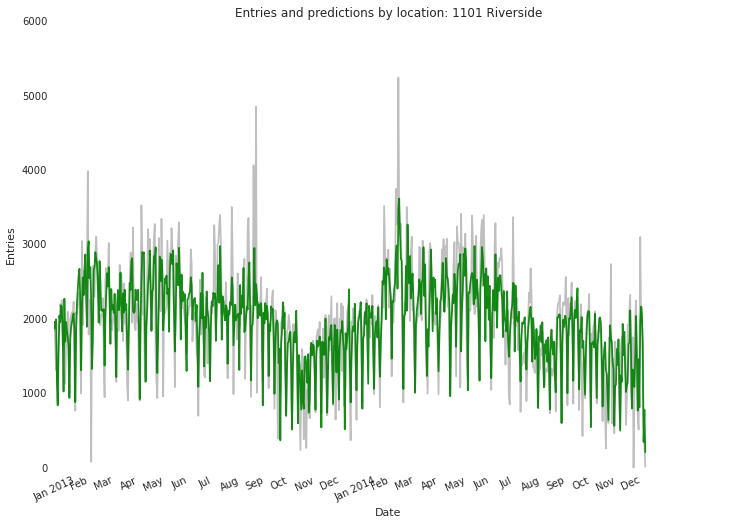

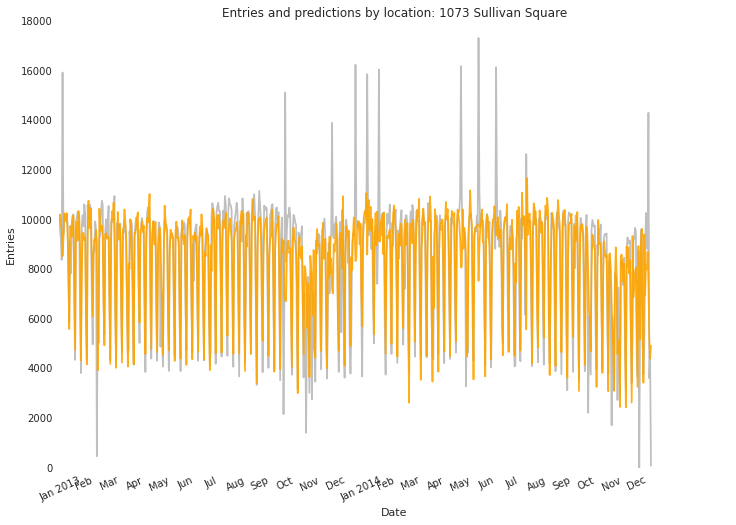

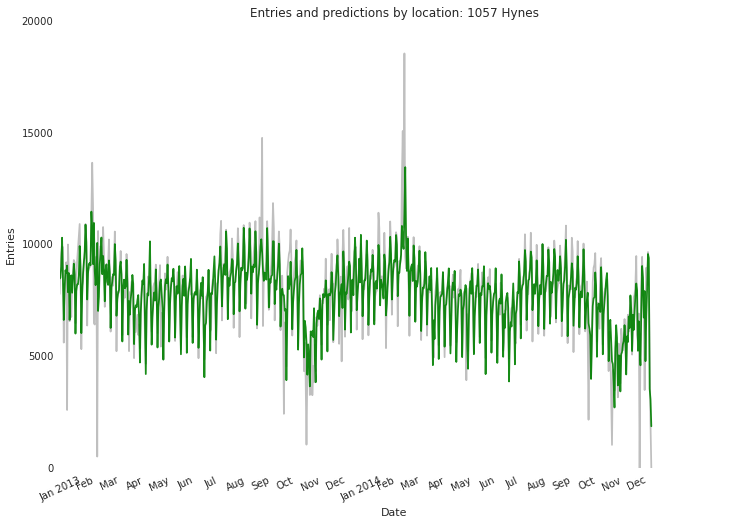

In [76]:
#plot lowest R2
plotEntriesByLoc(1058) #prudential
plotEntriesByLoc(1059) #kenmore
plotEntriesByLoc(1101) #riverside
plotEntriesByLoc(1073) #sullivan sq
plotEntriesByLoc(1057) #hynes



In [77]:
#highest R^2s
locationpreds.sort(['R2All'], ascending=[0]).head()


,locationid,locationname,line_1,line_2,lat,lon,R2All
11,1015,Suffolk Downs,Blue,NaN,42.388402,-71.000358,0.922593
15,1019,Bowdoin,Blue,NaN,42.361457,-71.062129,0.866923
46,1077,State Street,Orange,Blue,42.358897,-71.057795,0.860072
8,1012,Aquarium,Blue,NaN,42.359456,-71.053570,0.854124
5,1009,South Station,Red,NaN,42.351710,-71.055000,0.845935


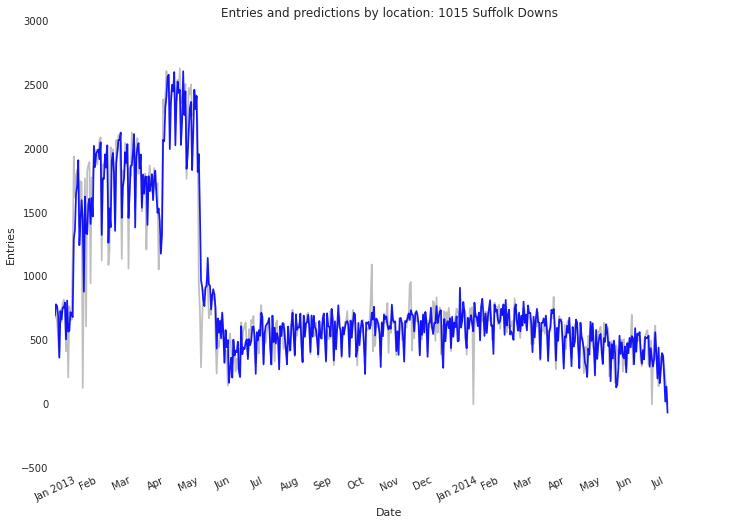

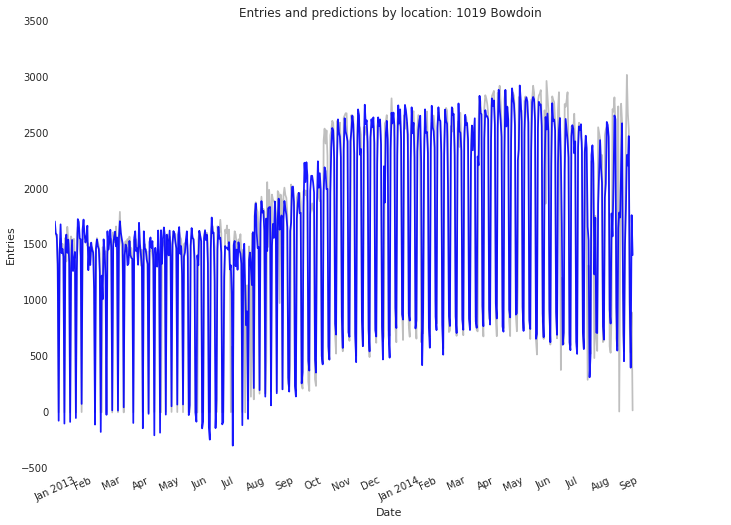

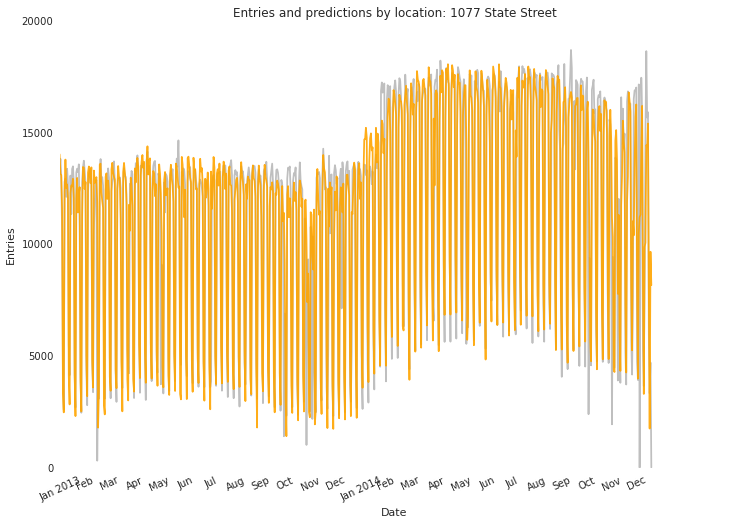

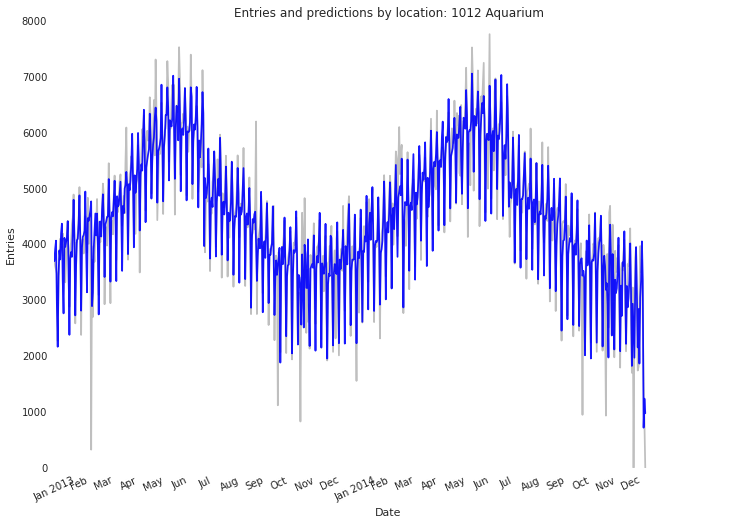

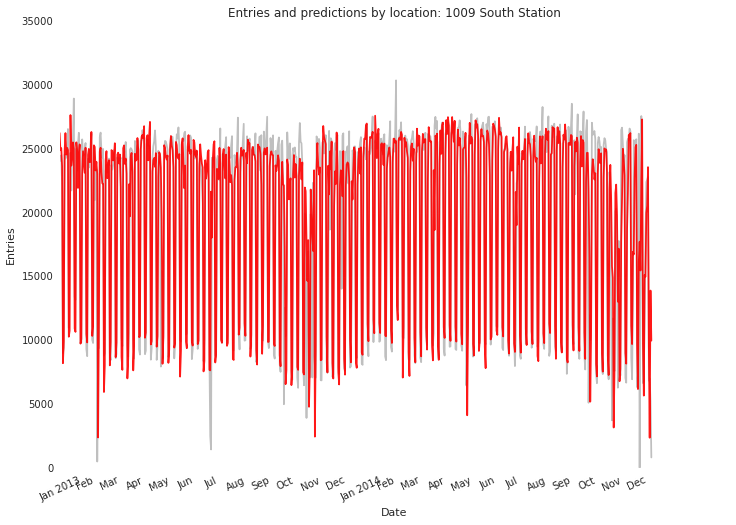

In [78]:
#plot highest
plotEntriesByLoc(1015) #suffolk
plotEntriesByLoc(1019) #bowdoin
plotEntriesByLoc(1077) #state street
plotEntriesByLoc(1012) #aquarium
plotEntriesByLoc(1009) #south station


#### R^2 score for test data:

In [79]:
#Simple linear case
def predict_test(X_train,Y_train, X_test, Y_test):
    # Create the simplest basis, with just the time and an offset.

    #define parameters of model
    clf = LinearRegression() 

    #fit model using selected regresion
    clf.fit(X_train, Y_train)
    
    #predict
    Y_pred = clf.predict(X_test)

    return sklearn.metrics.r2_score(Y_test, Y_pred), Y_pred

In [80]:
def predictByLocation(locid, last2014=False):
    train_size=.8
    
    # Set up feature, output containers
    loc_prediction_data = features_full.ix[features_full.locationid == locid,:]

    Y = np.array(loc_prediction_data.entries)
    X = np.array(loc_prediction_data.drop(['locationid','entries'],axis=1))

    # Generate samples and divide into training and testing sets.
    #REMOVE:
    np.random.seed(500)
    
    if(last2014):
        train_indices = range(int(np.floor(len(X)*train_size)), len(X))
        test_indices  = [i for i in range(len(X)) if i not in train_indices] 
        
        X_train = X[train_indices,:]
        Y_train = Y[train_indices]
        X_test  = X[test_indices,:]
        Y_test  = Y[test_indices]
        
    else:
        train_indices = np.random.choice(range(len(X)), np.floor(len(X) * train_size), replace=False)
        test_indices  = [i for i in range(len(X)) if i not in train_indices] 
        X_train = X[train_indices,:]
        Y_train = Y[train_indices]
        X_test  = X[test_indices,:]
        Y_test  = Y[test_indices]
    
    
    score, pred = predict_test(X_train,Y_train, X_test, Y_test)
    
    return score, pred, Y_test

In [81]:
locationpreds_test = locations.copy()
locationpreds_test['R2test'] = 0.0

for index, row in locationpreds_test.iterrows():
    locid = row.locationid
    #print locid
    
    score, pred, test = predictByLocation(locid)
    
    #print pred
    locationpreds_test.R2test[index] = score
    #break

locationpreds = locationpreds_test

In [82]:
#lowest R^2s
locationpreds.sort(['R2test'], ascending=[1]).head()

,locationid,locationname,line_1,line_2,lat,lon,R2test
36,1059,Kenmore Square,Green,NaN,42.348797,-71.095296,0.418203
37,1060,Science Park,Green,NaN,42.366678,-71.068164,0.424737
42,1073,Sullivan Square,Orange,NaN,42.385755,-71.077080,0.430057
57,1101,Riverside,Green,NaN,42.337111,-71.251734,0.436241
13,1017,Revere Beach,Blue,NaN,42.407163,-70.992193,0.454365


In [83]:
#highest R^2s
locationpreds.sort(['R2test'], ascending=[0]).head()

,locationid,locationname,line_1,line_2,lat,lon,R2test
11,1015,Suffolk Downs,Blue,NaN,42.388402,-71.000358,0.913925
8,1012,Aquarium,Blue,NaN,42.359456,-71.053570,0.859569
4,1007,Quincy Center,Red,NaN,42.250879,-71.004798,0.838040
15,1019,Bowdoin,Blue,NaN,42.361457,-71.062129,0.833943
2,1005,North Quincy,Red,NaN,42.274816,-71.029176,0.820745


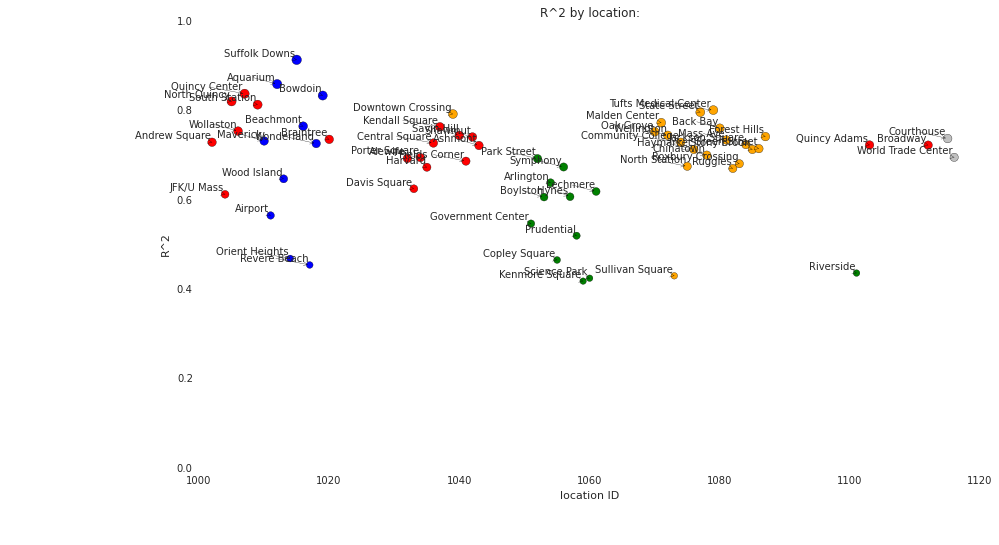

In [86]:


labels = locationpreds.locationname.tolist()

plt.figure(figsize=(14,8))
#plt.subplots_adjust(bottom = 0.1)

plt.scatter(
    locationpreds.locationid, locationpreds.R2test, marker = 'o', 
    c = locationpreds.line_1, s = locationpreds.R2test*100,
    cmap = plt.get_cmap('Spectral'))

for label, x, y in zip(labels, locationpreds.locationid, locationpreds.R2test):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-2, 2),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.title('R^2 by location:')
plt.xlabel('location ID') 
plt.ylabel('R^2')
plt.axis([1000, 1120, 0, 1])
plt.show()

In [87]:
def predictAndCompare(locid, last=False):
    score, pred, test = predictByLocation(locid, last)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(range(test.shape[0]), test, color='gray')
    plt.plot(range(pred.shape[0]), pred, color='blue')
    plt.show

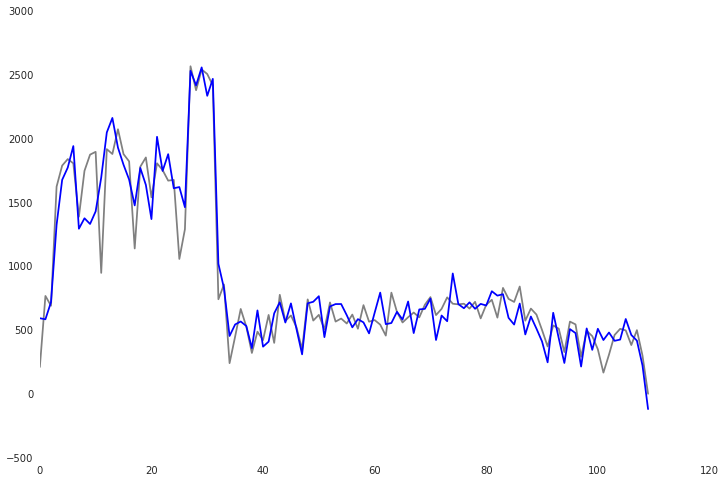

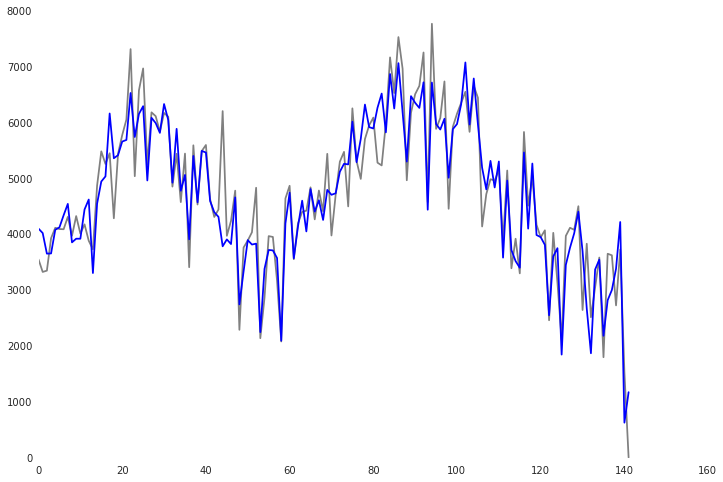

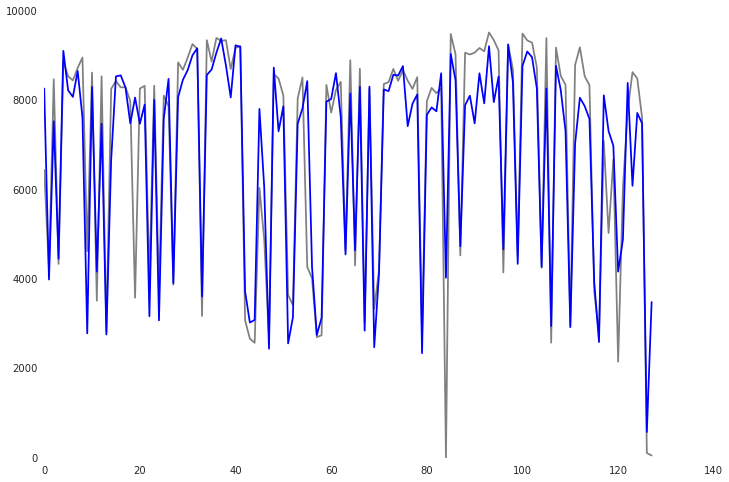

In [88]:
predictAndCompare(1015)
predictAndCompare(1012)
predictAndCompare(1007)


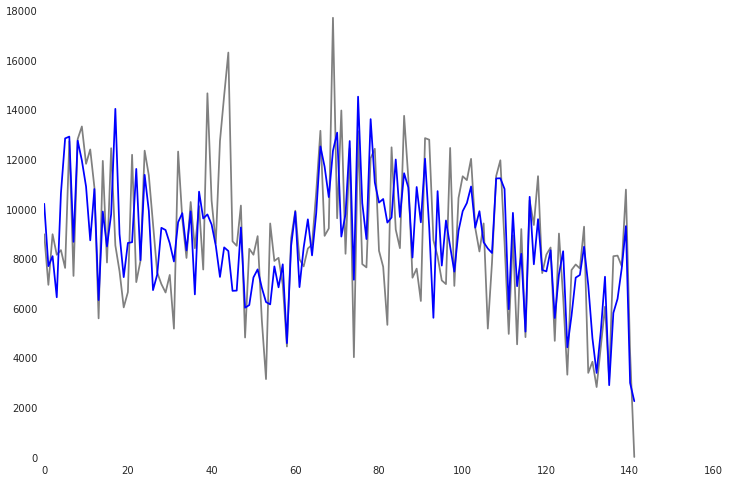

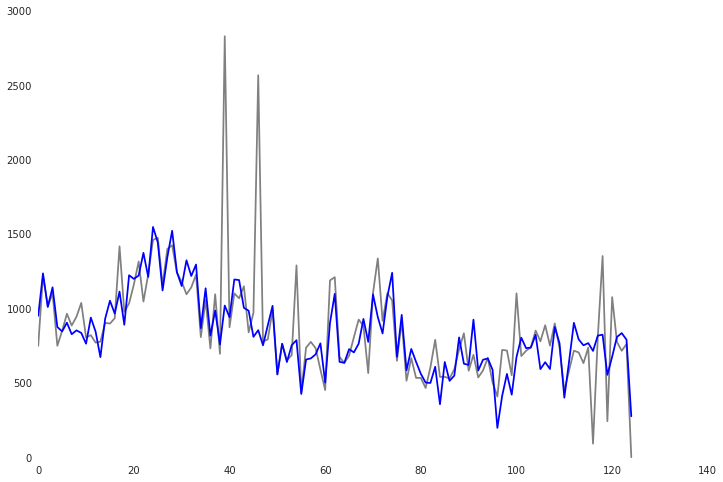

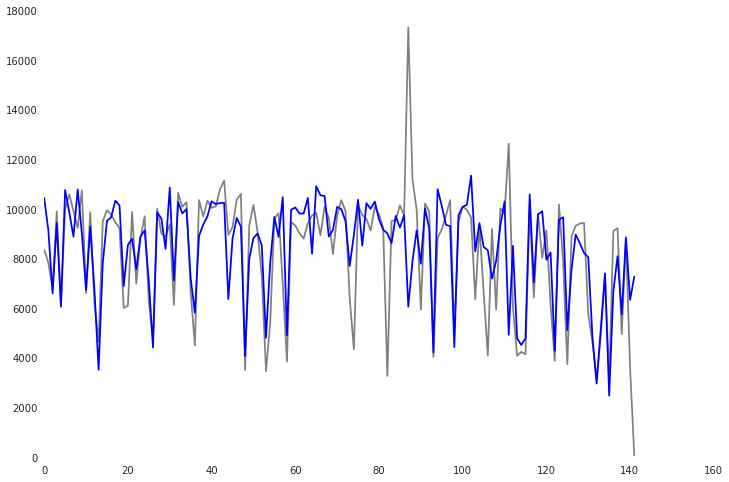

In [89]:
predictAndCompare(1059)
predictAndCompare(1060)
predictAndCompare(1073)